# Задача 4. Ансамбли

* **Дедлайн**: 26.03.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] * (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] * (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ydata_profiling as yp
%matplotlib inline

# Датасет

Используемый датасет [Churn modelling](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling)

Этот набор данных содержит сведения о клиентах банка. Целевая переменная является бинарной и отражает тот факт, покинул ли клиент банк (закрыл свой счет) или он продолжает оставаться клиентом.

Нецелевые аттрибуты:
1. CustomerId - идентификатор клиента
2. Surname - фамилия
3. CreditScore - кредитный рейтинг
4. Geography - страна проживания
5. Genger - пол
6. Age - возраст
7. Tenure - сколько лет является клиентом банка
8. Balance - сколько денег на счету
9. NumOfProducts - количество продуктов банка, которыми клиент пользуется
10. HasCrCard - количество кредитных карт
11. IsActiveMember - бинарная переменная, определяющая был ли клиент активным перед уходом из компании
12. EstimatedSalary - приблизительная зарплата

Целевой аттрибут:
1. Exited - бинарная переменная, определяющая, закрыл ли клиент аккаунт

In [148]:
df = pd.read_csv('Churn_Modelling.csv')

# EDA

Сразу удалим из набора данных такие аттрибуты как номер строки и идентификатор клиента, поскольку они не имеют предсказательной силы.

In [149]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [150]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Проверим, есть ли null значения

In [152]:
df.isnull().any().any()

False

In [153]:
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

Рассмотрим данные по нецелевым аттрибутам при разных значениях целевого

In [154]:
df[df['Exited'] == False].describe().T.style.background_gradient(subset=[]).format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
CreditScore,7963.00,651.85,95.65,405.00,585.00,653.00,718.00,850.00
Age,7963.00,37.41,10.13,18.00,31.00,36.00,41.00,92.00
Tenure,7963.00,5.03,2.88,0.00,3.00,5.00,7.00,10.00
Balance,7963.00,72745.30,62848.04,0.00,0.00,92072.68,126410.28,221532.80
NumOfProducts,7963.00,1.54,0.51,1.00,1.00,2.00,2.00,3.00
HasCrCard,7963.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,7963.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,7963.00,99738.39,57405.59,90.07,50783.49,99645.04,148609.96,199992.48
Exited,7963.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [155]:
df[df['Exited'] == True].describe().T.style.background_gradient(subset=[]).format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
CreditScore,2037.00,645.35,100.32,350.00,578.00,646.00,716.00,850.00
Age,2037.00,44.84,9.76,18.00,38.00,45.00,51.00,84.00
Tenure,2037.00,4.93,2.94,0.00,2.00,5.00,8.00,10.00
Balance,2037.00,91108.54,58360.79,0.00,38340.02,109349.29,131433.33,250898.09
NumOfProducts,2037.00,1.48,0.80,1.00,1.00,1.00,2.00,4.00
HasCrCard,2037.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,2037.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
EstimatedSalary,2037.00,101465.68,57912.42,11.58,51907.72,102460.84,152422.91,199808.10
Exited,2037.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


Можно заметить, что у людей, которые покинули банк средний возраст выше на 7.43 года, несмотря на то, что длительность пользования банком практически не отличается

Построим распределение аттрибутов

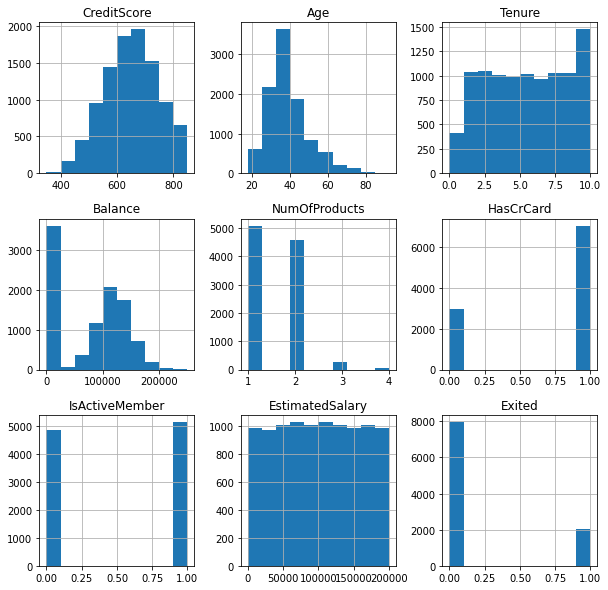

In [156]:
df.hist(figsize=(10, 10));

1. Можно заметить, что баланс почти у половины людей пустой баланс, у второй половины распределение плавное

2. Подавляющее большинство клиентов пользуется одним либо двумя продуктами банка, меньшинство -- тремя и четыремя

3. Четверть людей не имеет кредиток

4. Количество активных и неактивных пользователей на момент ухода практически совпадает

5. Всего из банка ушли около 20% клиентов

Построим матрицу корреляции аттрибутов

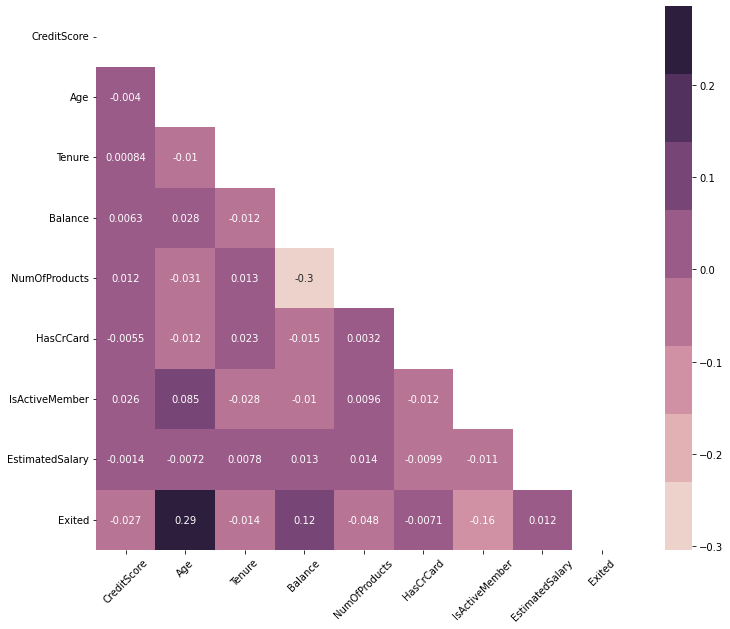

In [157]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap = sns.cubehelix_palette(8), mask=np.triu(df.corr()))
plt.xticks(rotation=45);

Как уже отметили раннее, существует слабая положительная корреляция между возрастом клиента и уходом из банка.
Также существует слабая отрицательная корреляция между количеством продуктов, которыми клиент пользовался и его балансом счета

Остальные корреляции аттрибутов незначительны

Посмотрим на влияние категориальных аттрибутов:

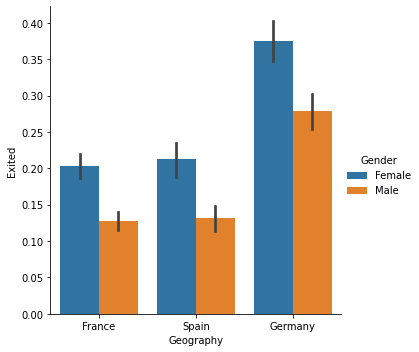

In [158]:
sns.catplot(data=df, x='Geography', y='Exited', hue='Gender', kind='bar');

В каждой стране женщины чаще мужчин покидали банк. Также в германии ощутимо больший процент и мужчин, и женщин покидает банк по сравнению с Францией и Испанией, где показатели не сильно отличаются

Таким образом, можно предположить, что большей показательной силой будут обладать такие аттрибуты как возраст, пол, страна проживания

Теперь закодируем категориальные аттрибуты:

In [159]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

In [160]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


# Bagging

In [472]:
import numpy as np
from typing import Tuple
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator

In [564]:
from collections import Counter

def most_common(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

class SimpleBaggingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator=None, n_estimators=10, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleBaggingClassifier":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)
        
        self.estimator_ = self.estimator or DecisionTreeClassifier()
        self.classes_ = np.unique(y)

        self.estimators_ = []
        for _ in range(self.n_estimators):
            estimator = clone(self.estimator_)
            self._set_random_states(estimator)
            X_sample, y_sample = self._bootstrap_resample(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return np.apply_along_axis(
            most_common,
            axis=0,
            arr=[estimator.predict(X) for estimator in self.estimators_],
        )
    
    def _set_random_states(self, estimator):
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_
        estimator.set_params(**random_states)

    def _bootstrap_resample(self, X: npt.NDArray, y: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
        bootstrap_indices = self.random_state_.choice(len(y), size=len(y))
        return X[bootstrap_indices], y[bootstrap_indices]


check_estimator(SimpleBaggingClassifier())

# AdaBoost

In [565]:
class SimpleAdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=50, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleAdaBoostClassifier":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)
        
        self.estimator_ = self.estimator or DecisionTreeClassifier(max_depth=3)
        self.classes_ = np.unique(y)

        self.estimators_ = []
        self.estimator_weights_ = []
        sample_weight = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)
            errors = predicted != y
            avg_error = np.sum(sample_weight * errors) / np.sum(sample_weight)
            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif avg_error >= 0.5:
                if not self.estimators_:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break
                
            beta = avg_error / (1 - avg_error)
            sample_weight *= np.power(beta, 1 - errors)  
            sample_weight /= np.sum(sample_weight)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T
        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.estimator_weights_[sorted_prediction_ids], axis=1)
        more_than_median = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)
        median_ids = np.argmax(more_than_median, axis=1)  
        median_ids = sorted_prediction_ids[np.arange(len(X)), median_ids]
        return predictions[np.arange(len(X)), median_ids]


check_estimator(SimpleAdaBoostClassifier())

# Optuna

In [566]:
import pathlib
import warnings

import optuna
from sklearn.model_selection import KFold, cross_validate

optuna.logging.set_verbosity(optuna.logging.WARNING) 
optuna.logging.set_verbosity(optuna.logging.INFO)

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

RESULTS_PATH = pathlib.Path("cv_results.csv")
DATA = df.drop(columns=['Exited'])
TARGET = df['Exited']

def train_and_save(estimator, params):
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(),
        direction="maximize",
    )

    optuna_model = optuna.integration.OptunaSearchCV(
        estimator,
        params,
        n_jobs=2,
        n_trials=None,  
        random_state=34,
        study=study,
    )

    cv_results = cross_validate(
        optuna_model,
        DATA,
        TARGET,
        cv=KFold(shuffle=True, random_state=42),
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=3,
        return_estimator=True,
    )
    
    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)
    
    cv_results = pd.DataFrame(cv_results)
    cv_results['estimator'] = estimator.__class__.__name__
    cv_results.to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [567]:
%%time

train_and_save(
    SimpleBaggingClassifier(random_state=0),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2023-03-25 20:06:09,261] A new study created in memory with name: no-name-3443f628-adbf-441a-b785-5771e9b1390d


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: user 82.7 ms, sys: 17.3 ms, total: 100 ms
Wall time: 14 s


In [568]:
%%time
from sklearn.ensemble import BaggingClassifier

train_and_save(
    BaggingClassifier(random_state=1, n_jobs=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2023-03-25 20:06:23,265] A new study created in memory with name: no-name-14ba53c4-9af5-4a2d-bfb6-e6a27187a57e


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: user 68.3 ms, sys: 14.4 ms, total: 82.8 ms
Wall time: 9.78 s


In [569]:
%%time
from sklearn.ensemble import RandomForestClassifier

train_and_save(
    RandomForestClassifier(random_state=2, n_jobs=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 50]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    },
)

[I 2023-03-25 20:06:33,049] A new study created in memory with name: no-name-e7fae4ec-a61b-4070-98e8-04c886397d9e


Best params #1: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': 100}
Best params #2: {'n_estimators': 20, 'max_features': None, 'max_leaf_nodes': 100}
Best params #3: {'n_estimators': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None}
Best params #4: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': 100}
Best params #5: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': 100}
CPU times: user 66.8 ms, sys: 12.5 ms, total: 79.3 ms
Wall time: 38.5 s


In [570]:
%%time

train_and_save(
    SimpleAdaBoostClassifier(random_state=3),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2023-03-25 20:07:11,544] A new study created in memory with name: no-name-446ce25a-30bb-428e-a2c2-2852ad5c1870


Best params #1: {'n_estimators': 20}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: user 72.7 ms, sys: 0 ns, total: 72.7 ms
Wall time: 5.82 s


In [571]:
%%time
from sklearn.ensemble import AdaBoostClassifier

train_and_save(
    AdaBoostClassifier(random_state=4),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2023-03-25 20:07:17,367] A new study created in memory with name: no-name-9e2e3446-22c4-474c-9af9-2ee5665abd45


Best params #1: {'learning_rate': 0.3, 'n_estimators': 40}
Best params #2: {'learning_rate': 0.3, 'n_estimators': 40}
Best params #3: {'learning_rate': 0.3, 'n_estimators': 40}
Best params #4: {'learning_rate': 0.3, 'n_estimators': 40}
Best params #5: {'learning_rate': 0.3, 'n_estimators': 40}
CPU times: user 35.5 ms, sys: 4.65 ms, total: 40.1 ms
Wall time: 8.76 s


In [572]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

train_and_save(
    GradientBoostingClassifier(random_state=5),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    },
)

[I 2023-03-25 20:07:26,134] A new study created in memory with name: no-name-a68aefaa-3db3-42cd-842f-e32fc8ab25fb


Best params #1: {'learning_rate': 0.03}
Best params #2: {'learning_rate': 0.03}
Best params #3: {'learning_rate': 0.03}
Best params #4: {'learning_rate': 0.03}
Best params #5: {'learning_rate': 0.03}
CPU times: user 45.1 ms, sys: 540 µs, total: 45.6 ms
Wall time: 12.1 s


In [573]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

train_and_save(
    HistGradientBoostingClassifier(random_state=6),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.2, 0.3]),
        "max_iter": optuna.distributions.CategoricalDistribution([100, 300, 500]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([3, 15, 40]),
        "early_stopping": optuna.distributions.CategoricalDistribution([False, True]),
    },
)

[I 2023-03-25 20:07:38,207] A new study created in memory with name: no-name-59368bec-c15d-4e72-a497-758649dd3723


Best params #1: {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 15, 'early_stopping': False}
Best params #2: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 3, 'early_stopping': False}
Best params #3: {'learning_rate': 0.3, 'max_iter': 300, 'max_leaf_nodes': 3, 'early_stopping': False}
Best params #4: {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 15, 'early_stopping': False}
Best params #5: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 3, 'early_stopping': False}
CPU times: user 113 ms, sys: 21.2 ms, total: 134 ms
Wall time: 30min 40s


In [574]:
%%time
from xgboost import XGBClassifier

train_and_save(
    XGBClassifier(random_state=7, n_jobs=2),
    params={
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    },
)

[I 2023-03-25 20:38:18,357] A new study created in memory with name: no-name-8a0e9a4c-5507-4cb8-bda7-67327680c753


Best params #1: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 3}
Best params #2: {'tree_method': 'exact', 'learning_rate': 0.1, 'n_estimators': 100, 'max_leaves': 40}
Best params #3: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 3}
Best params #4: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 100, 'max_leaves': 15}
Best params #5: {'tree_method': 'approx', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 3}
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1min 34s


In [575]:
%%time
from lightgbm import LGBMClassifier

train_and_save(
    LGBMClassifier(random_state=8, n_jobs=2),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "num_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    },
)

[I 2023-03-25 20:39:53,136] A new study created in memory with name: no-name-24a7a372-d48a-4836-8bdc-3792ca504553


Best params #1: {'learning_rate': 0.03, 'n_estimators': 100, 'num_leaves': 40}
Best params #2: {'learning_rate': 0.03, 'n_estimators': 100, 'num_leaves': 40}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15}
Best params #4: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 3}
Best params #5: {'learning_rate': 0.3, 'n_estimators': 20, 'num_leaves': 15}
CPU times: user 2.08 s, sys: 4.35 ms, total: 2.08 s
Wall time: 9.98 s


In [576]:
%%time
from catboost import CatBoostClassifier

train_and_store(
    CatBoostClassifier(random_state=9, thread_count=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 300, 500]),
    },
)

[I 2023-03-25 20:40:03,126] A new study created in memory with name: no-name-b188f255-ba87-40fd-940f-05fd31770a8a


Best params #1: {'n_estimators': 300}
Best params #2: {'n_estimators': 300}
Best params #3: {'n_estimators': 500}
Best params #4: {'n_estimators': 500}
Best params #5: {'n_estimators': 500}
CPU times: user 120 ms, sys: 3.68 ms, total: 123 ms
Wall time: 18.3 s


In [ ]:
results = pd.read_csv(RESULTS_PATH)

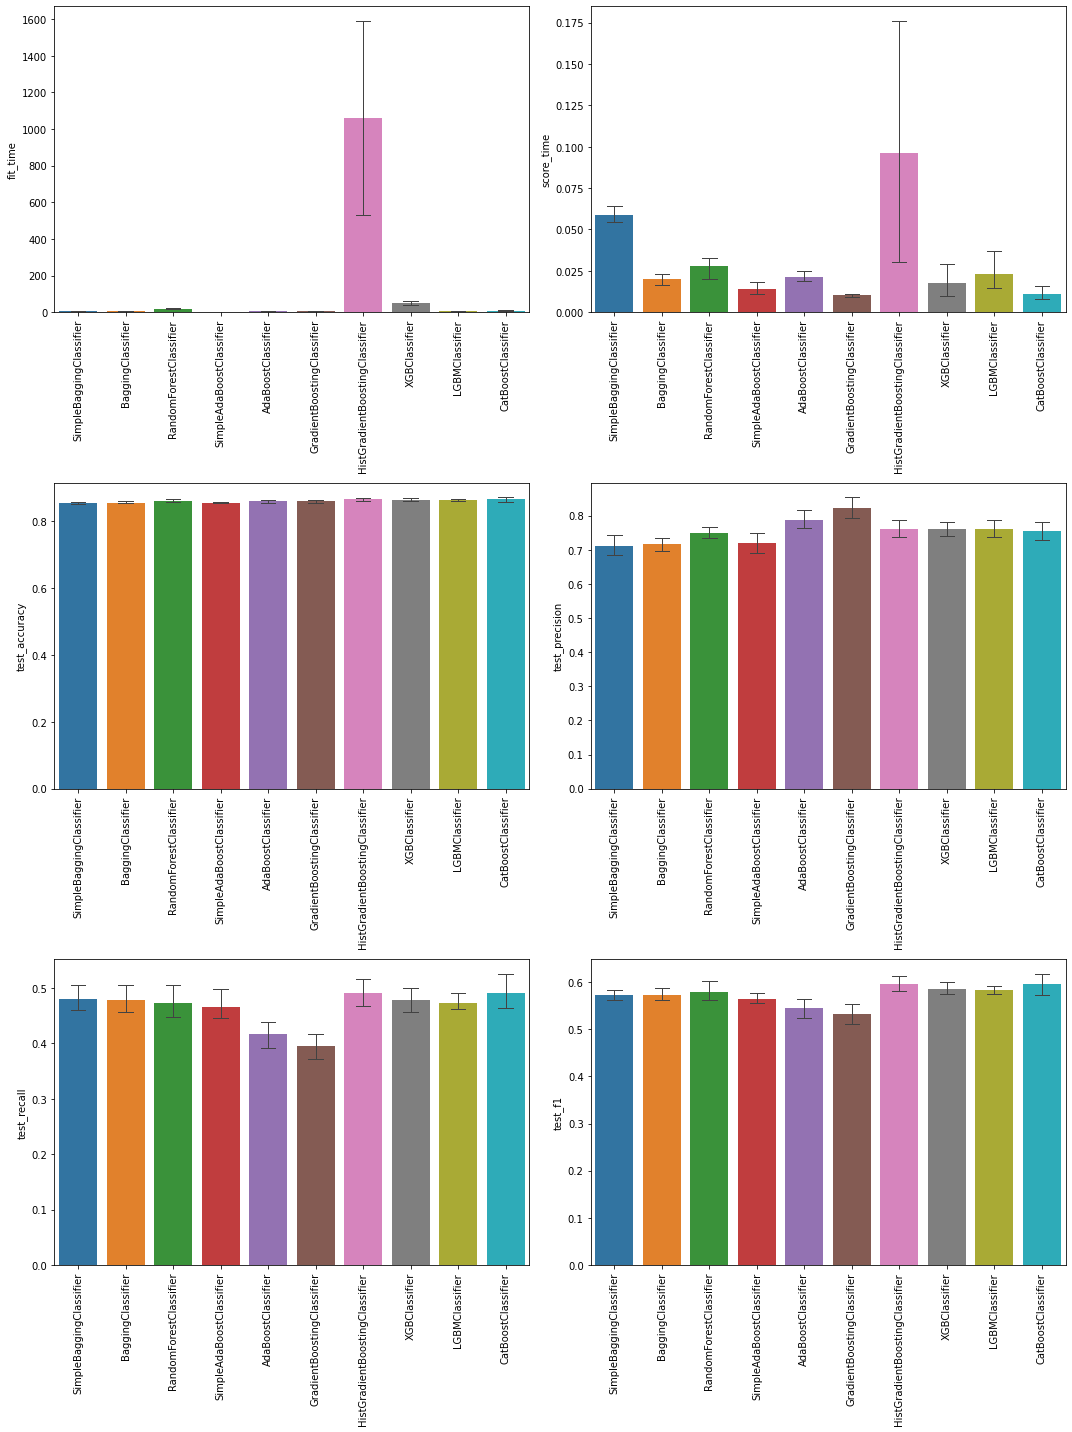

In [586]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 20))

for y, ax in zip(
    ["fit_time",
     "score_time",
     "test_accuracy",
     "test_precision",
     "test_recall",
     "test_f1"
    ], axs.flatten()):
    sns.barplot(results[["estimator", y]], x="estimator", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

По метрике `accuracy` все классификаторы показывают идентичные результаты, но немного лидируют Histogram-based gradient boosting и CatBoost, выдавая правильные прогнозы в 87% случаев, однако Histogram-based gradient boosting существенно проигрывает по скорости.

По метрике `precision` явно лидирует градиентный бустинг, однако он показывает наихудший результат по метрике `recall`. 

По совокупности метрик, включая скорость обучения, наилучшие результаты показал CatBoost.